In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from scipy.signal import hilbert

import sys
sys.path.append('..')
from cann import CANN1D


import warnings
warnings.filterwarnings("ignore")

#set backend to cpu
bm.set_platform('cpu') 

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SystemError: initialization of _internal failed without raising an exception

## negative correlation between activity and step size

In [ ]:
replay_dur = 5000      #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

def get_results(mbar, sigma_m=0.1, sigma_u=0.02, downsamplerate=20):
    #initialize the network
    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=sigma_m, sigma_u=sigma_u)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    noise = 0.00* bm.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center', 'r'],
                        progress_bar=False)

    replay_runner_1.run(length)

    replay_start = int(init_dur/replay_runner_1.dt)

    bum_center = replay_runner_1.mon.center
    #squeeze the array
    bum_center = np.squeeze(bum_center)[replay_start:]

    fr = bm.as_numpy(replay_runner_1.mon.r)
    fr = fr[replay_start:, :]
    
    #downsample
    fr = fr[::downsamplerate, :]
    bum_center = bum_center[::downsamplerate]

    #get the mean fr for each time step]
    # fr_thres = np.max(fr)
    # fr = np.where(fr<fr_thres/10, 0, fr)
    ave_fr = np.sum(fr, axis=1)
    # ave_fr = np.mean(fr, axis=1)

    #caulcte the stepsize of the bump_center
    stepsize = np.abs(np.diff(bum_center, axis=0))
    #add 0 at the beginning of the array
    stepsize = np.insert(stepsize, 0, 0, axis=0)

    #remove stepsize that is more than 1 for periodic boundary effect
    index = stepsize > 0.8
    stepsize = stepsize[~index]
    ave_fr = ave_fr[~index]
    bump_center = bum_center[~index]
    
    return stepsize, ave_fr, bump_center



### simulate the newtwork N times and plot the relationship between fr and step size

In [ ]:
N = 30

all_stepsize = {}
all_fr = {}
all_bump_center = {}

#!!! @Tianhao: change the mbar value to add adaptation to the network 

for simulation_i in range(N):
    stepsize, ave_fr, bump_center = get_results(mbar=0.99, sigma_m=0.3, sigma_u=0.02, downsamplerate=200)
    
    #change stepsize from m to cm
    stepsize = stepsize * 100
    #time all_fr_list by 1000 to get Hz 
    ave_fr = ave_fr * 100
    
    all_stepsize[simulation_i] = stepsize
    all_fr[simulation_i] = ave_fr
    all_bump_center[simulation_i] = bump_center
    print(simulation_i/N)
 


0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


/tmp/ipykernel_69400/944488964.py:21: RuntimeWarning: Mean of empty slice
  fr_i_binned = [np.nanmean(fr_i[inds==i]) for i in range(1, len(bins))]


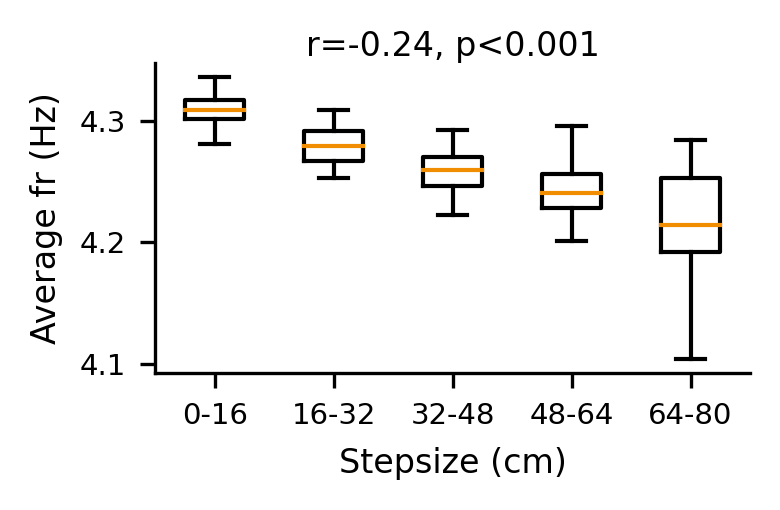

In [ ]:
#scatter plot of stepsize and fr
fig, ax = plt.subplots(1, 1, figsize=(2.7,1.8), dpi=300)
labelsize = 8
ticksize = 8

all_stepsize_list = np.concatenate(list(all_stepsize.values()))
all_fr_list = np.concatenate(list(all_fr.values())) 

#bin the step size and get the mean fr in each binned stepsize
#this will make the negtive correlation more obvious

#find the max stepsize by min max of all_stepsize_list
max_stepsize = np.max(all_stepsize_list)
all_fr_binned = {}
for key in all_stepsize.keys():
    stepsize_i = all_stepsize[key]
    fr_i = all_fr[key]
    
    bins  = np.linspace(0, max_stepsize, 6)
    inds = np.digitize(stepsize_i, bins)
    fr_i_binned = [np.nanmean(fr_i[inds==i]) for i in range(1, len(bins))]

    all_fr_binned[key] = fr_i_binned[0:]
    
#chaneg the dictionary to array
all_fr_binned = np.array(list(all_fr_binned.values()))

#repalce nan value with mean in that column
for column_i in range(all_fr_binned.shape[1]):
    nan_index = np.isnan(all_fr_binned[:, column_i])
    all_fr_binned[nan_index, column_i] = np.nanmean(all_fr_binned[:, column_i])

#do boxplot with showing nanmean and nanmedian  

ax.boxplot(all_fr_binned, showmeans=True, meanline=True, showfliers=False, 
            flierprops=dict(markersize=3), 
            meanprops=dict(color='#F18D00', linestyle='-', linewidth=1), 
            medianprops=dict(color='#009FB9', alpha=0))

#pearson correlation of new_stepsize and new_fr
r, p = scipy.stats.pearsonr(all_stepsize_list, all_fr_list)
if p<0.001:
    ax.set_title(f'r={r:.2f}, p<0.001', transform=plt.gca().transAxes, fontsize=ticksize)
else:
    ax.set_title(f'r={r:.2f}, p={p:.3f}', transform=plt.gca().transAxes, fontsize=ticksize)
    

ax.set_xlabel('Stepsize (cm)', fontsize=labelsize)
ax.set_ylabel('Average fr (Hz)', fontsize=labelsize)

# #xticks as the bin cneter
# ax.set_xticks([np.mean([bins[i], bins[i+1]]) for i in range(0, len(bins)-1)])
#set the xlabels for each bin using values in bins, leep one decimal
ax.set_xticklabels([f'{bins[i]:.0f}-{bins[i+1]:.0f}' for i in range(0, len(bins)-1)], rotation=0, ha='center')

#yticks without decimal
ax.yaxis.set_major_formatter('{x:.1f}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=ticksize-1)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig4_modelprediction3_activity_stepsize.pdf', dpi=300)
    

## Anti phase locking with slow-gamma input

In [ ]:
def get_phase(slowgamma):
    """
    get the phase of the slow gamma using hilbert transform
    """
    analytic_signal = hilbert(slowgamma)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + 0*np.pi, 2 * np.pi) - np.pi
    
    return instantaneous_phase

In [ ]:
replay_dur = 10000      #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

def get_results(mbar, sigma_m=0.1, sigma_u=0.02, oscillation_strength=0.5, oscilation_period=40, downsamplerate=20):
    #initialize the network
    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=sigma_m, sigma_u=sigma_u)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    x_time, x_dim = Iext.shape
    x = np.arange(x_time)
    
    #geterante the oscillatory input, the period is oscilation_period ms, the strength is oscilaltion_strength
    #the shape is the same as Iext, using sin function
    oscillatory_input = oscillation_strength * np.sin(2*np.pi*x/oscilation_period/10) #/10 since dt=0.1
    #subtratc the minimum value to make sure the oscillatory_input is always positive
    #oscillatory_input = oscillatory_input - np.min(oscillatory_input)
    #copy each value in oscillatory_input into dimension x_dim, make oscillatory_input the same shape as Iext
    oscillatory_input = np.tile(oscillatory_input, (x_dim, 1)).T
    
    
    Iext = Iext + oscillatory_input
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['center', 'r', 'u', 'v'],
                        progress_bar=False)

    replay_runner_1.run(length)

    replay_start = int(init_dur/replay_runner_1.dt)

    bump_center = replay_runner_1.mon.center
    #squeeze the array
    bump_center = np.squeeze(bump_center)[replay_start:]

    oscillatory_input = oscillatory_input[replay_start:]

    fr = bm.as_numpy(replay_runner_1.mon.r)
    fr = fr[replay_start:, :]

    #get the mean fr for each time step]
    #fr_thres = np.max(fr)
    fr = np.where(fr<0, 0, fr)
    
    #ave_fr = np.max(fr, axis=1)
    summed_fr = np.sum(fr, axis=1)
    
    #ave_fr = ave_fr[::downsamplerate]
    #downsample ave_fr by taking the sum every downsamplerate
    summed_fr = np.array([np.mean(summed_fr[i:i+downsamplerate]) for i in range(0, len(summed_fr), downsamplerate)])
    #downsample bump_center, oscillatory_input
    bump_center = bump_center[::downsamplerate]
    oscillatory_input = oscillatory_input[::downsamplerate]

    #caulcte the stepsize of the bump_center
    stepsize = np.diff(bump_center)
    #remove the effect of periodic boundary, if the stepsize is larger than pi, then minus 2pi, if the stepsize is smaller than -pi, then add 2pi
    stepsize = np.where(stepsize>np.pi, stepsize-2*np.pi, stepsize)
    stepsize = np.where(stepsize<-np.pi, stepsize+2*np.pi, stepsize)
    
    stepsize = np.abs(stepsize)
    #add 0 at the beginning of the array
    stepsize = np.insert(stepsize, 0, 0, axis=0)
    
    #get v
    v = bm.as_numpy(replay_runner_1.mon.v)
    v = v[replay_start:, :]
    v = np.where(v<0, 0, v)
    summed_v = np.sum(v, axis=1)
    summed_v = np.array([np.mean(summed_v[i:i+downsamplerate]) for i in range(0, len(summed_v), downsamplerate)])
    
    #get u
    u = bm.as_numpy(replay_runner_1.mon.u)
    u = u[replay_start:, :]
    u = np.where(u<0, 0, u)
    summed_u = np.sum(u, axis=1)
    summed_u = np.array([np.mean(summed_u[i:i+downsamplerate]) for i in range(0, len(summed_u), downsamplerate)])
    
    return stepsize, summed_fr, summed_u, summed_v,bump_center, oscillatory_input

stepsize, summed_fr, summed_u, summed_v, bump_center, oscillatory_input = get_results(mbar=0.99, sigma_m=0.3, sigma_u=0.02, oscillation_strength=0.05, oscilation_period=25, downsamplerate=10)


#change stepsize from m to cm
stepsize = stepsize * 100
#time all_fr_list by 1000 to get Hz 
summed_fr = summed_fr * 1000

#smooth the stepsize and mean_fr for visualization
stepsize = scipy.ndimage.gaussian_filter1d(stepsize, sigma=5)
summed_fr = scipy.ndimage.gaussian_filter1d(summed_fr, sigma=5)

In [ ]:
init = 1200
duration=200
st = stepsize[init:init+duration]
gamma_oscillation_probe = oscillatory_input[init:init+duration,0]
summed_fr_probe = summed_fr[init:init+duration]

Peaks_gamma,_ = scipy.signal.find_peaks(-gamma_oscillation_probe)


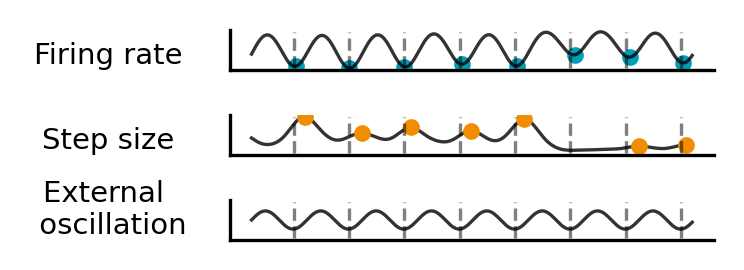

In [ ]:

fig = plt.figure(figsize=(2.7, 1), dpi=300)
labelsize = 8
ticksize = 8
gs = gridspec.GridSpec(3, 1)

###########
#subplot 0#
###########

ax0 = plt.subplot(gs[0,:])
#mark the trough of summed_fr_probe
Peaks_fr,_ = scipy.signal.find_peaks(-summed_fr_probe)
ax0.plot(Peaks_fr, summed_fr_probe[Peaks_fr], marker='o', linestyle='None', markersize=3, color='#009FB9')    

ax0.plot(summed_fr_probe, color='black', linewidth=0.8, alpha=0.8)
for peaks in Peaks_gamma:
    ax0.plot([peaks, peaks],[np.min(summed_fr_probe),np.max(summed_fr_probe)],'k--', linewidth=0.8, alpha=0.5)
    
#add xlabel and ylabel and chang label to two lines, rotating y label to horizontal
ax0.set_ylabel('Firing rate', fontsize=labelsize-1, rotation=0, ha='center', labelpad=30)
ax0.yaxis.set_label_coords(-0.25, 0.)
#set x ticks
ax0.set_xticks([])
ax0.set_yticks([])

###########
#subplot 1#
###########

ax1 = plt.subplot(gs[1,:])

# 
ax1.plot(st, color='black', linewidth=0.8, alpha=0.8)
# ax0.plot(st, color='#F18D00', marker='o', linestyle='None', markersize=1)
#mark the peaks of st
Peaks_st,_ = scipy.signal.find_peaks(st)
ax1.plot(Peaks_st, st[Peaks_st], marker='o', linestyle='None', markersize=3, color='#F18D00')

#add vertical lines
for peaks in Peaks_gamma:
    ax1.plot([peaks, peaks],[0,np.max(st)],'k--', linewidth=0.8, alpha=0.5)
    
#add ylabel
ax1.set_ylabel('Step size', fontsize=labelsize-1, rotation=0, ha='center', labelpad=30)
ax1.yaxis.set_label_coords(-0.25, 0.)    
ax1.set_xticks([])
ax1.set_yticks([])

###########
#subplot 2#
###########

ax2 = plt.subplot(gs[2,:])

ax2.plot(gamma_oscillation_probe, color='black', linewidth=0.8, alpha=0.8)
for peaks in Peaks_gamma:
    ax2.plot([peaks, peaks],[np.min(gamma_oscillation_probe)-0.05,np.max(gamma_oscillation_probe)+0.05],'k--', linewidth=0.8, alpha=0.5)

#add xlabel and ylabel and chang label to two lines
# ax11.set_xlabel('Time (ms)', fontsize=labelsize)
ax2.set_ylabel('External \n oscillation', fontsize=labelsize-1, rotation=0, ha='center', labelpad=30)
ax2.yaxis.set_label_coords(-0.25, 0.)

#set y ticks off for the second subplot
ax2.set_yticks([])
#set x ticks
ax2.set_xticks([])

#for ax0 ax1 ax2, set spine invisible for top and right
for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.yaxis.set_label_coords(-0.2, 0.5)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig4_modelprediction3_antiphase_locking_1.pdf')

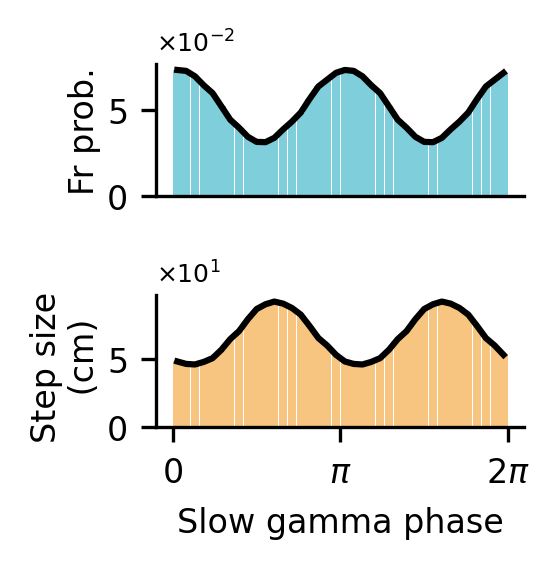

In [ ]:
fig = plt.figure(figsize=(2, 2), dpi=300)
labelsize = 8
ticksize = 8
gs = gridspec.GridSpec(2, 1)

oscillatory_input_channel_1 = oscillatory_input[:,0]
#zscore the oscillatory_input_channel_1
oscillatory_input_channel_1 = (oscillatory_input_channel_1 - np.mean(oscillatory_input_channel_1))/np.std(oscillatory_input_channel_1)
phase = get_phase(oscillatory_input_channel_1) #phase=0 is the peak of the oscillation

phase_bins = np.linspace(-np.pi, np.pi, 20)
#count the number stepsize and firing rate in each phase bin
stepsize_phase = np.zeros(len(phase_bins)-1)
fr_phase = np.zeros(len(phase_bins)-1)
phase_bin_centers = np.zeros(len(phase_bins)-1)
for i in range(len(phase_bins)-1):
    index = np.where((phase>=phase_bins[i]) & (phase<phase_bins[i+1]))[0]
    stepsize_phase[i] = np.mean(stepsize[index])
    fr_phase[i] = np.mean(summed_fr[index])
    phase_bin_centers[i] = phase_bins[i] + (phase_bins[i+1]-phase_bins[i])/2

#normalize fr_phase with sum
fr_phase_norm = fr_phase/np.sum(fr_phase)


#repeat the stepsize_phase again and fr_phase again 
stepsize_phase_double= np.append(stepsize_phase, stepsize_phase)
fr_phase_norm_double = np.append(fr_phase_norm, fr_phase_norm)
phase_bins_double = np.append(phase_bin_centers, phase_bin_centers+2*np.pi)

#plot the stepsize_phase and fr_phase in histogram
ax2 = plt.subplot(gs[0,0])
ax2.plot(phase_bins_double, fr_phase_norm_double, color='k')
ax2.bar(phase_bins_double, fr_phase_norm_double, width=2*np.pi/len(phase_bins), color='#009FB9', alpha=0.5)


ax2.set_ylabel('Fr prob.', fontsize=labelsize, ha='center')
#ylabel in scientific notation with smaller font size
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax2.yaxis.get_offset_text().set_fontsize(labelsize-2)  # Adjust the font size of the offset text

    
#set x ticks off
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', labelsize=ticksize)

###########
#subplot 3#
###########

ax3 = plt.subplot(gs[1,0])


ax3.plot(phase_bins_double, stepsize_phase_double, color='k')
ax3.bar(phase_bins_double, stepsize_phase_double, width=2*np.pi/len(phase_bins), color='#F18D00', alpha=0.5)

#add y label
ax3.set_ylabel('Step size \n (cm)', fontsize=labelsize, ha='center')
#ylabel in scientific notation
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax3.yaxis.get_offset_text().set_fontsize(labelsize-2)  # Adjust the font size of the offset text
    
#add x label
ax3.set_xlabel('Slow gamma phase', fontsize=labelsize)

#add xticks
ax3.set_xticks([-np.pi, np.pi, 3*np.pi])
#add xticklabels and yticklabels
ax3.set_xticklabels(['0', '$\pi$', '$2\pi$'])
#set x and y tick font size
ax3.tick_params(axis='both', which='major', labelsize=ticksize)

#for ax0 ax1 ax2, set spine invisible for top and right
for ax in [ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_coords(-0.15, 0.5)

plt.tight_layout()

#save
plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig4_modelprediction3_antiphase_locking_2.pdf')

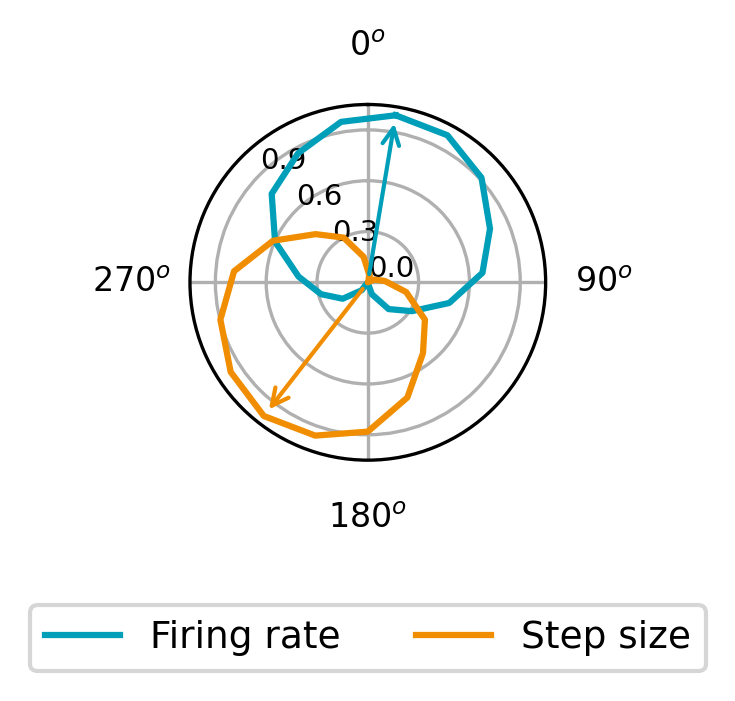

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=300)
labelsize = 8
ticksize = 8
gs = gridspec.GridSpec(1, 1)

ax3 = plt.subplot(gs[0,0], projection='polar')

stepsize_phase = (stepsize_phase-np.min(stepsize_phase))/(np.max(stepsize_phase)-np.min(stepsize_phase))
fr_phase_norm2 = (fr_phase-np.min(fr_phase))/(np.max(fr_phase)-np.min(fr_phase))

stepsize_phase_pad = np.append(stepsize_phase, stepsize_phase[0])
fr_phase_pad = np.append(fr_phase_norm2, fr_phase_norm2[0])
phase_bin_centers_pad = np.append(phase_bin_centers, phase_bin_centers[0])

phase_bin_centers_pad += np.pi #shift the phase_bin_centers_pad by pi to make 0 as the oscillation trogh, previously -pi is the oscillation trough

#%%
ax3.plot(phase_bin_centers_pad, fr_phase_pad, color='#009FB9')
ax3.plot(phase_bin_centers_pad, stepsize_phase_pad, color='#F18D00')

#calculate peak phase_r and phase_step
peak_phase_r = phase_bin_centers_pad[np.argmax(fr_phase_pad)]
peak_phase_step = phase_bin_centers_pad[np.argmax(stepsize_phase_pad)]

#add arrows representing the peak phase_r and phase_step
#pointing from the center to the peak, make the arrow thicker with a arrow style ->
#using annotate function
ax3.annotate("", xy=(peak_phase_r, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='#009FB9', linewidth=1))
ax3.annotate("", xy=(peak_phase_step, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='#F18D00', linewidth=1))
#add grid
ax3.grid(True)

#add legend for the two lines below the polar plot
ax3.legend(['Firing rate', 'Step size'], bbox_to_anchor=(0.5, -0.5), fontsize=ticksize+1, ncol=2, loc='center')

#set tick size
ax3.tick_params(labelsize=ticksize)
ax3.set_rticks([0,  0.3, 0.6, 0.9])
#reduce rticks size
for label in ax3.get_yticklabels():
    label.set_fontsize(ticksize-1)
ax3.set_rlabel_position(-45)

#set tick and tick labels
ax3.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi])
#pad ticklabels
ax3.set_xticklabels(['$0^o$', '$90^o$', '$180^o$', '$270^o$'], fontsize=ticksize)

#make the polar plot degree increase anti-clockwise and put zero degree at the top
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig4_modelprediction3_antiphase_locking_3.pdf')